In [14]:
import cmdstanpy
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [15]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

In [16]:
df = pd.read_excel('cereal.xlsx', index_col=0)

df

,Manufacturer,type,calories per serving,grams of protein,grams of fat,milligrams of sodium,grams of dietary fiber,grams of complex carbohydrates,grams of sugars,milligrams of potassium,vitamins and minerals (% of FDA recommendation),Display shelf,Weight in ounces per one serving,Number of cups in one serving,Rating of cereal
Apple Cinnamon Cheerios,General Mills,Cold,110,2,2,180,1.5,10.5,10,70,25,1,1.00,0.75,29.509541
Basic 4,General Mills,Cold,130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562
Cheerios,General Mills,Cold,110,6,2,290,2.0,17.0,1,105,25,1,1.00,1.25,50.764999
Cinnamon Toast Crunch,General Mills,Cold,120,1,3,210,0.0,13.0,9,45,25,2,1.00,0.75,19.823573
Clusters,General Mills,Cold,110,3,2,140,2.0,13.0,7,105,25,3,1.00,0.50,40.400208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rice Chex,Ralston Purina,Cold,110,1,0,240,0.0,23.0,2,30,25,1,1.00,1.13,41.998933
Wheat Chex,Ralston Purina,Cold,100,3,1,230,3.0,17.0,3,115,25,1,1.00,0.67,49.787445
Maypo,American Home Food Products,Hot,100,4,1,0,0.0,16.0,3,95,25,2,1.00,1.00,54.850917
Cream of Wheat (Quick),Nabisco,Hot,100,3,0,80,1.0,21.0,0,-1,0,2,1.00,1.00,64.533816


<AxesSubplot:>

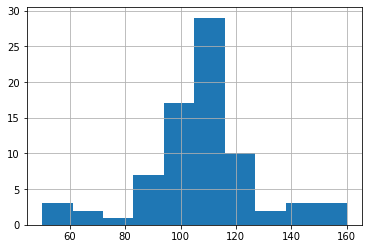

In [17]:
df['calories per serving'].hist()

<AxesSubplot:>

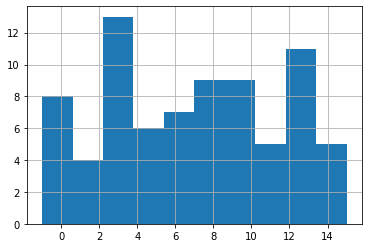

In [18]:
df['grams of sugars'].hist()

In [19]:
new_data = df[['calories per serving' ,'grams of sugars']]

In [20]:
new_data

,calories per serving,grams of sugars
Apple Cinnamon Cheerios,110,10
Basic 4,130,8
Cheerios,110,1
Cinnamon Toast Crunch,120,9
Clusters,110,7
...,...,...
Rice Chex,110,2
Wheat Chex,100,3
Maypo,100,3
Cream of Wheat (Quick),100,0


In [21]:
new_data.describe()

,calories per serving,grams of sugars
count,77.000000,77.000000
mean,106.883117,6.922078
std,19.484119,4.444885
min,50.000000,-1.000000
25%,100.000000,3.000000
50%,110.000000,7.000000
75%,110.000000,11.000000
max,160.000000,15.000000


In [22]:
model_ppc=cmdstanpy.CmdStanModel(stan_file='cereal_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [23]:
R = 1000
sim = model_ppc.sample(iter_sampling=R, iter_warmup=0, chains=1, fixed_param=True, seed=12062022, refresh=R, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [24]:
mu_sim=sim.stan_variable('mu')
sigma_sim=sim.stan_variable('sigma')
calories_sim=sim.stan_variable('calories')

(array([  1.,   2.,   2.,   6.,  16.,  55., 262., 542.,  75.,  23.,   6.,
          4.,   3.,   0.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([-800.399  , -673.94505, -547.4911 , -421.03715, -294.5832 ,
        -168.12925,  -41.6753 ,   84.77865,  211.2326 ,  337.68655,
         464.1405 ,  590.59445,  717.0484 ,  843.50235,  969.9563 ,
        1096.41025, 1222.8642 , 1349.31815, 1475.7721 , 1602.22605,
        1728.68   ]),
 <BarContainer object of 20 artists>)

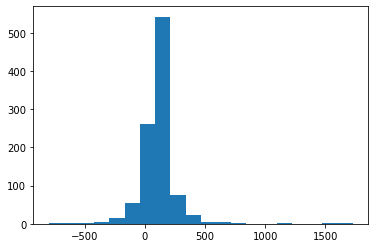

In [25]:
plt.hist(calories_sim, bins=20)

In [26]:
model_1_fit=cmdstanpy.CmdStanModel(stan_file='cereal_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [27]:
fit_1=model_1_fit.sample(data=dict(N=len(new_data['calories per serving']), calories=new_data['calories per serving'].values), seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [28]:
az.summary(fit_1, var_names=['mu', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,106.87,2.24,102.72,111.03
sigma,19.80,1.63,16.73,22.80


In [29]:
mu_fit = fit_1.stan_variable('mu')
sigma_fit = fit_1.stan_variable('sigma')
calorie_pred = fit_1.stan_variable('calorie')

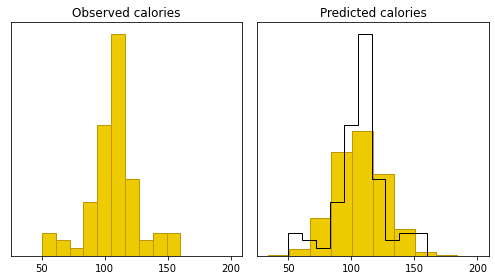

In [30]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(new_data['calories per serving'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed calories')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred, bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(new_data['calories per serving'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted calories')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8496\1829738190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['c_sugars'] = new_data['grams of sugars']-new_data['grams of sugars'].mean()


<AxesSubplot:>

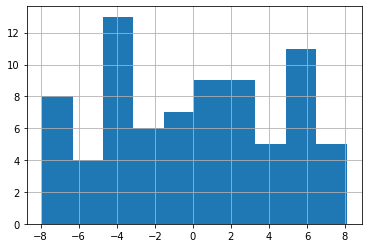

In [31]:
new_data['c_sugars'] = new_data['grams of sugars']-new_data['grams of sugars'].mean()
new_data['c_sugars'].hist()

In [32]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_2a_ppc.stan')

INFO:cmdstanpy:compiling stan file C:\GitHub\DataAnalyticsProject\cereal_2a_ppc.stan to exe file C:\GitHub\DataAnalyticsProject\cereal_2a_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\GitHub\DataAnalyticsProject\cereal_2a_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/GitHub/DataAnalyticsProject/cereal_2a_ppc.hpp C:/GitHub/DataAnalyticsProject/cereal_2a_ppc.stan
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_2a_ppc.stan', line 3, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_2a_ppc.stan', line 10, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be chang

In [33]:
R = 1000
data_sim = {'N': len(new_data), 'sugars':np.linspace(new_data['c_sugars'].min(),new_data['c_sugars'].max(), num=len(new_data))}

sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [34]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

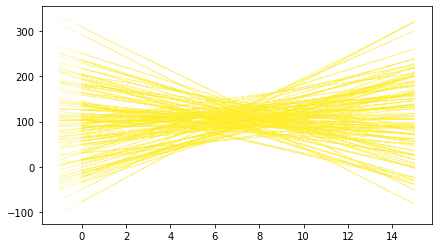

In [35]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(new_data['grams of sugars'], alpha_sim[i]+beta_sim[i]*new_data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)

plt.show()

In [36]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file C:\GitHub\DataAnalyticsProject\cereal_2b_ppc.stan to exe file C:\GitHub\DataAnalyticsProject\cereal_2b_ppc.exe
INFO:cmdstanpy:compiled model executable: C:\GitHub\DataAnalyticsProject\cereal_2b_ppc.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/GitHub/DataAnalyticsProject/cereal_2b_ppc.hpp C:/GitHub/DataAnalyticsProject/cereal_2b_ppc.stan
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_2b_ppc.stan', line 3, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_2b_ppc.stan', line 10, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be chang

In [37]:
sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [38]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

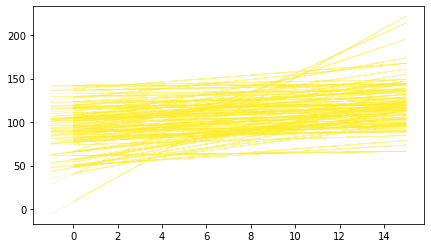

In [39]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(new_data['grams of sugars'], alpha_sim[i]+beta_sim[i]*new_data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)

plt.show()

In [40]:
calorie_sim = sim.stan_variable('calorie')

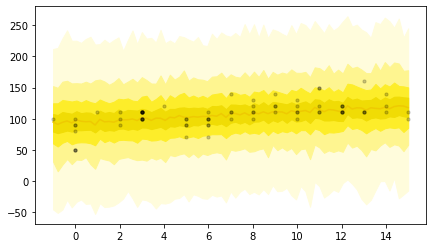

In [41]:
fig, axes = plt.subplots(1,1,figsize = (7,4))
axes=ribbon_plot(data_sim['sugars']+new_data['grams of sugars'].mean(),calorie_sim,axes)
axes.scatter(new_data['grams of sugars'], new_data['calories per serving'], color = 'black', alpha = 0.2, s=10)
plt.show()

In [42]:
model_2_fit = cmdstanpy.CmdStanModel(stan_file='cereal_2_fit.stan')

INFO:cmdstanpy:compiling stan file C:\GitHub\DataAnalyticsProject\cereal_2_fit.stan to exe file C:\GitHub\DataAnalyticsProject\cereal_2_fit.exe
INFO:cmdstanpy:compiled model executable: C:\GitHub\DataAnalyticsProject\cereal_2_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/GitHub/DataAnalyticsProject/cereal_2_fit.hpp C:/GitHub/DataAnalyticsProject/cereal_2_fit.stan
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_2_fit.stan', line 4, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_2_fit.stan', line 26, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed auto

In [43]:
data_fit = dict(N=len(new_data),
                sugars=new_data['c_sugars'].values,
                calories=new_data['calories per serving'].values)

fit_2=model_2_fit.sample(data=data_fit, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [44]:
alpha_fit = fit_2.stan_variable('alpha')
beta_fit = fit_2.stan_variable('beta')
mu_fit = fit_2.stan_variable('mu')
calorie_pred = fit_2.stan_variable('calorie')

In [45]:
az.summary(fit_2, var_names=['alpha', 'beta', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,106.88,1.86,103.40,110.35
beta,2.31,0.43,1.53,3.15
sigma,16.53,1.38,14.05,19.12


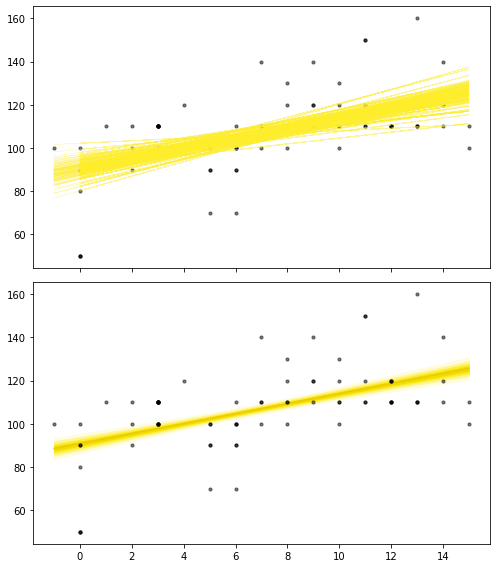

In [46]:
fig, axes = plt.subplots(2,1,figsize = (7,8), sharey=True, sharex=True)
ax0=axes[0]

for i in range(100):
    ax0.plot(new_data['grams of sugars'],
            alpha_fit[i]+beta_fit[i]*new_data['c_sugars'],
            color=MID,
            alpha=0.5, linewidth=0.5)

ax0.scatter(new_data['grams of sugars'], new_data['calories per serving'], color='black', alpha=0.5, s=10)

ax1=axes[1]
ax1=ribbon_plot(new_data['grams of sugars'].values, mu_fit, ax1, supress_warning=True)
ax1.scatter(new_data['grams of sugars'], new_data['calories per serving'], color='black', alpha=0.5, s=10)
fig.tight_layout()
plt.show()

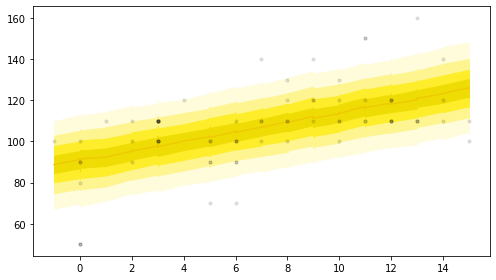

In [47]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

axes=ribbon_plot(new_data['grams of sugars'].values, calorie_pred, axes, supress_warning=True)
axes.scatter(new_data['grams of sugars'], new_data['calories per serving'], color='black', alpha=0.1, s=10)
fig.tight_layout()
plt.show()

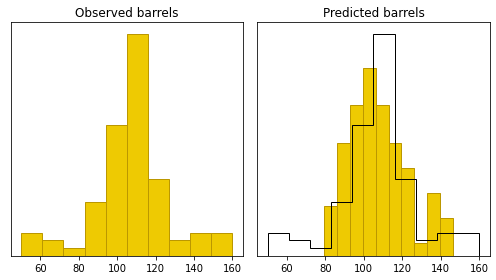

In [48]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(new_data['calories per serving'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed barrels')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred[99], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(new_data['calories per serving'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted barrels')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

In [49]:
fit_id_2 = az.from_cmdstanpy(posterior=fit_2,log_likelihood='log_lik')

In [50]:
fit_id_2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [51]:
model_3_fit = cmdstanpy.CmdStanModel(stan_file='cereal_3_fit.stan')

INFO:cmdstanpy:compiling stan file C:\GitHub\DataAnalyticsProject\cereal_3_fit.stan to exe file C:\GitHub\DataAnalyticsProject\cereal_3_fit.exe
INFO:cmdstanpy:compiled model executable: C:\GitHub\DataAnalyticsProject\cereal_3_fit.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/GitHub/DataAnalyticsProject/cereal_3_fit.hpp C:/GitHub/DataAnalyticsProject/cereal_3_fit.stan
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_3_fit.stan', line 4, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/GitHub/DataAnalyticsProject/cereal_3_fit.stan', line 28, column 3: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed auto

In [52]:
data_fit = dict(N=len(new_data),
                sugars=new_data['c_sugars'].values,
                calories=new_data['calories per serving'].values)

fit_3=model_3_fit.sample(data=data_fit, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [53]:
alpha_fit = fit_3.stan_variable('alpha')
beta_fit = fit_3.stan_variable('beta')
mu_fit = fit_3.stan_variable('mu')
calorie_pred = fit_3.stan_variable('calorie')

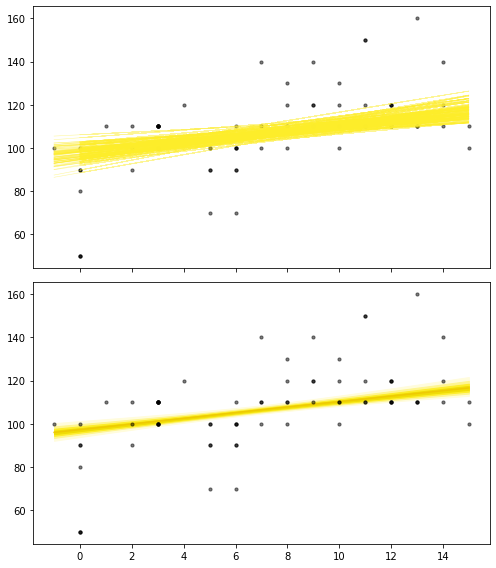

In [54]:
fig, axes = plt.subplots(2,1,figsize = (7,8), sharey=True, sharex=True)
ax0=axes[0]

for i in range(100):
    ax0.plot(new_data['grams of sugars'],
            alpha_fit[i]+beta_fit[i]*new_data['c_sugars'],
            color=MID,
            alpha=0.5, linewidth=0.5)

ax0.scatter(new_data['grams of sugars'], new_data['calories per serving'], color='black', alpha=0.5, s=10)

ax1=axes[1]
ax1=ribbon_plot(new_data['grams of sugars'].values, mu_fit, ax1, supress_warning=True)
ax1.scatter(new_data['grams of sugars'], new_data['calories per serving'], color='black', alpha=0.5, s=10)
fig.tight_layout()
plt.show()

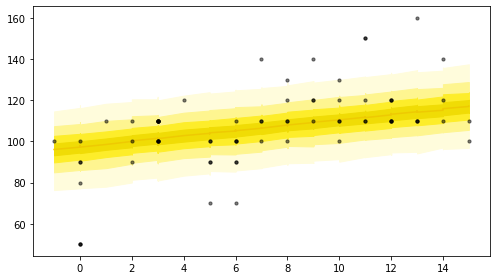

In [55]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

axes=ribbon_plot(new_data['grams of sugars'].values, calorie_pred, axes, supress_warning=True)
axes.scatter(new_data['grams of sugars'], new_data['calories per serving'], color='black', alpha=0.5, s=10)
fig.tight_layout()
plt.show()

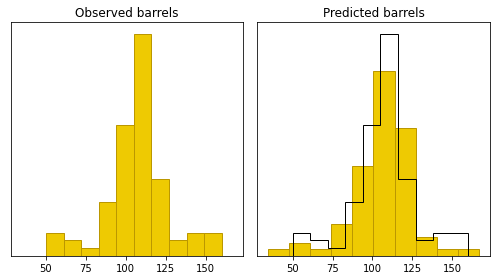

In [62]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(new_data['calories per serving'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed barrels')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred[99], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(new_data['calories per serving'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted barrels')
ax2.set_yticks(())
fig.tight_layout()

In [57]:
fit_id_3 = az.from_cmdstanpy(posterior=fit_3,log_likelihood='log_lik')

In [58]:
model_compare = az.compare({'Model 2':fit_id_2,'Model 3':fit_id_3})
model_compare

c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 3,0,-321.735281,3.474663,0.000000,0.99024,9.151028,0.000000,False,log
Model 2,1,-326.307285,3.571995,4.572004,0.00976,7.489353,2.950881,False,log


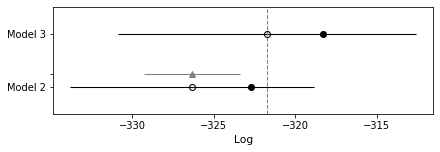

In [59]:
az.plot_compare(model_compare)
plt.show()

In [63]:
model_compare_2 = az.compare({'Model 2':fit_id_2,'Model 3':fit_id_3}, ic='waic')
model_compare_2

c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 3,0,-321.731144,3.470525,0.000000,0.987658,9.149884,0.000000,False,log
Model 2,1,-326.278991,3.543701,4.547847,0.012342,7.479930,2.952666,True,log


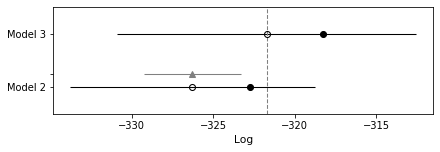

In [64]:
az.plot_compare(model_compare_2)
plt.show()